### Libraries

In [2]:
import cv2 as cv
import time
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
from functions import * # own functions

### **(Memory and Color)** Load a photo into open CV and:
##### Change the green and blue channels.

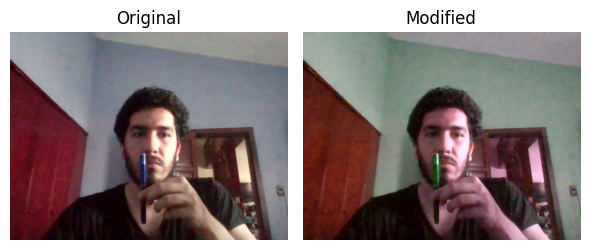

In [6]:
#frame = take_pic(2,"images/selfie.jpg",False)
frame = cv.imread("images/selfie.jpg")

b,g,r = cv.split(frame)
mod_frame = cv.merge((g,b,r))

plot_img(2,(6,3),["Original", "Modified"],[frame, mod_frame])

##### Convert the original image into gray scale.


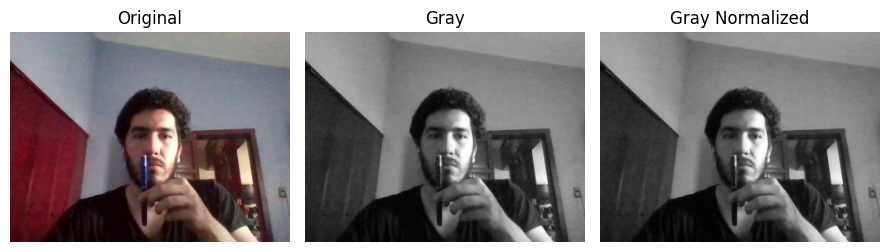

In [7]:
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
gray.astype(float)
grayN = cv.normalize(gray, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

plot_img(3,(9,4.5),["Original", "Gray", "Gray Normalized"],[frame, gray, grayN])

##### Convert the original image into HSV.

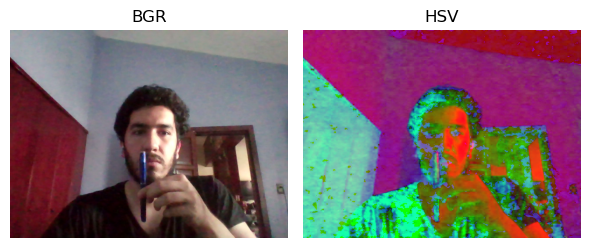

In [10]:
hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
plot_img(2,(6,3),["BGR", "HSV"],[frame, hsv])

### **(Capture)** Use a video capture to:
Estimate the f number of your camera.

Use a reference object and measure at know distance, count the number of pixels to estimate the f number.

In [13]:
# The previous image of me holding a pen was taking 50 cm away from the object (pen), and the length of the 
# pen in the picture is 161 px, while the real length is 14.5 cm. Therefore we can calculate the focal length as:
F = (161 * 50) / 14
print(f"The focal length of my camera is {F}") 

The focal length of my camera is 575.0


#### Use the estimate f number to measure the distance to a second reference object.
Repeat the experiment at least using thee different distances. Report the measurement error.


In [15]:
### Now I will estimate the distance three times to another object (a notebook with 17.9 cm of height)
for i in range(3):
    _ = take_pic(2,f"images/notebook_{i+1}.jpg",False)
    time.sleep(15) # To give me time to measure a new distance

Taking picture in 2 seconds...
Image saved at images/notebook_1.jpg
Taking picture in 2 seconds...
Image saved at images/notebook_2.jpg
Taking picture in 2 seconds...
Image saved at images/notebook_3.jpg


In [28]:
real_distances = [50, 70, 90] # in cm
px_distances = [187, 143, 110] # in px
estim_distances = [(17.9 * F) / x for x in px_distances]
perc_error = [(abs(real - estim) / real) * 100 for real, estim in zip(real_distances, estim_distances)]

print(f"The estimated distances in cm were: {', '.join([f'{dist:.2f}' for dist in estim_distances])} and the average percentage error was: {np.mean(perc_error):.2f}%")

The estimated distances in cm were: 55.04, 71.98, 93.57 and the average percentage error was: 5.62%


### **(Enhancing)** Use a reference image to:
Do histogram equalization.

Apply equalization independently to all channels.


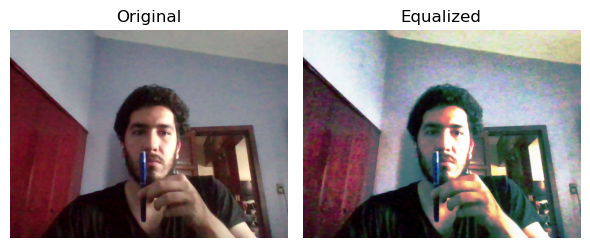

In [30]:
channels = b, g, r # from previous image of me holding a pen

eq_channels = [cv.equalizeHist(channel) for channel in channels]
eq_image = cv.merge(eq_channels)

plot_img(2,(6,3),["Original", "Equalized"],[frame, eq_image])

Apply equalization to the V channel on the HSV converted image. 

Once the V channel has been equalized convert back to RGB and display the image

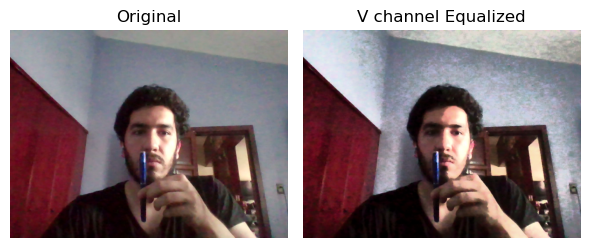

In [32]:
h,s,v = cv.split(hsv)
eq_v = cv.equalizeHist(v)
hsv_mod = cv.merge([h,s,eq_v])
brg_mod = cv.cvtColor(hsv_mod, cv.COLOR_HSV2BGR)

plot_img(2,(6,3),["Original", "V channel Equalized"],[frame, brg_mod])

Apply the gamma enhancing:

Enhance the low intensity areas.

Enhance the high intensity areas.

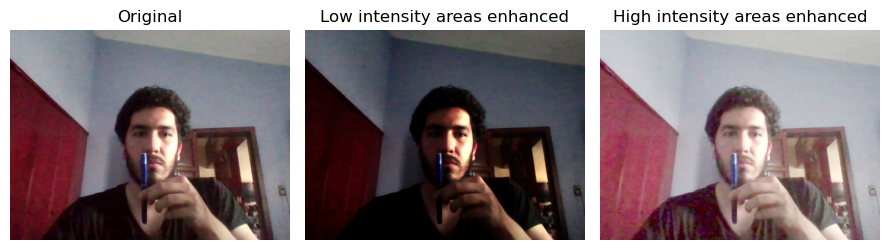

In [41]:
plot_img(3,(9,4.5),["Original", "Low intensity areas enhanced", "High intensity areas enhanced"],[frame, adjust_gamma(frame,0.5), adjust_gamma(frame,2)])

### **(Sampling)** Use your own image.
Do the pyramid representation:

Down sample the image to 2,4,8,16.
- Nearest neighbor


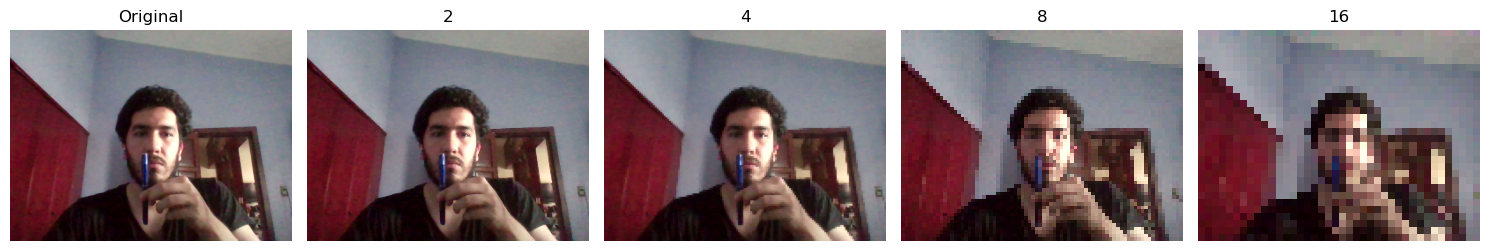

In [44]:
factors = [2, 4, 8, 16]

nn_imgs = []
for factor in factors:
    resample = cv.resize(frame, (frame.shape[1] // factor, frame.shape[0] // factor), interpolation=cv.INTER_NEAREST)
    nn_imgs.append(resample)

plot_img(5,(15,7.5),["Original", "2", "4", "8", "16"],[frame, nn_imgs[0], nn_imgs[1], nn_imgs[2], nn_imgs[3]])


- Bilinear filtering

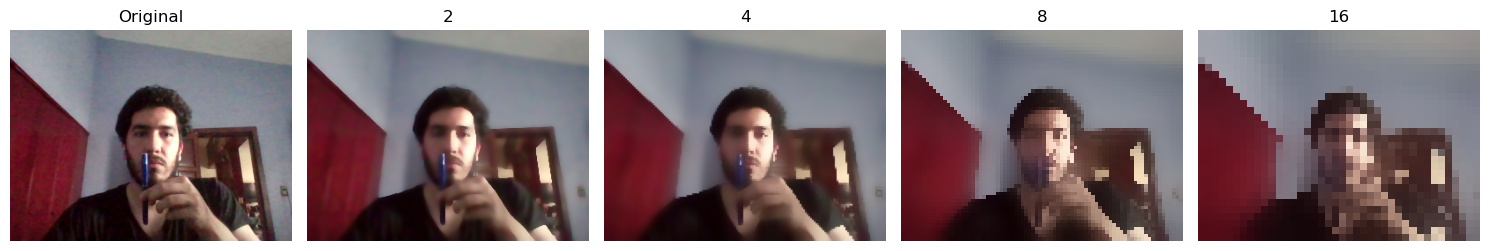

In [62]:
bf_imgs = []

for i, factor in enumerate(factors):
    resample = nn_imgs[i]
    filtered = cv.bilateralFilter(resample,9,120,120)
    bf_imgs.append(filtered)

plot_img(5,(15,7.5),["Original", "2", "4", "8", "16"],[frame, bf_imgs[0], bf_imgs[1], bf_imgs[2], bf_imgs[3]])

- Max pooling filtering

frame = cv.imread("images/selfie.jpg")

        Use the 1/16 representation and up sample to the original size:
            Use bilinear interpolation.
            Use SINC interpolation.

### **(Filtering)** Use your own image:

    Add gaussian noise:
        Apply mean filter.
        Apply median filter.
        Apply anisotropic filter.
    Add salt and pepper noise:
        Apply mean filter.
        Apply median filter.
        Apply anisotropic filter.
    Apply the following filters:
        Laplacian
        Sobel x
        Laplacian of Gaussian
        Sharpening


#### Investigate Homomorphic filter (https://en.wikipedia.org/wiki/Homomorphic_filtering Links to an external site.)
    Implement using only convolutions.
    Implement it on the Fourier domain.


Homomorphic filter: used to simultaneously normalize brightness across an image and enhance its contrast. It operates by applying a high-pass filter in the logarithmic domain
<ol>
    <li>Transform the image into the logarithmic domain.</li>
    <li>Apply a high-pass filter to the Fourier transform of the logarithmic image.</li>
    <li>Transform the result back to the spatial domain and exponentiate.</li>
<ol>

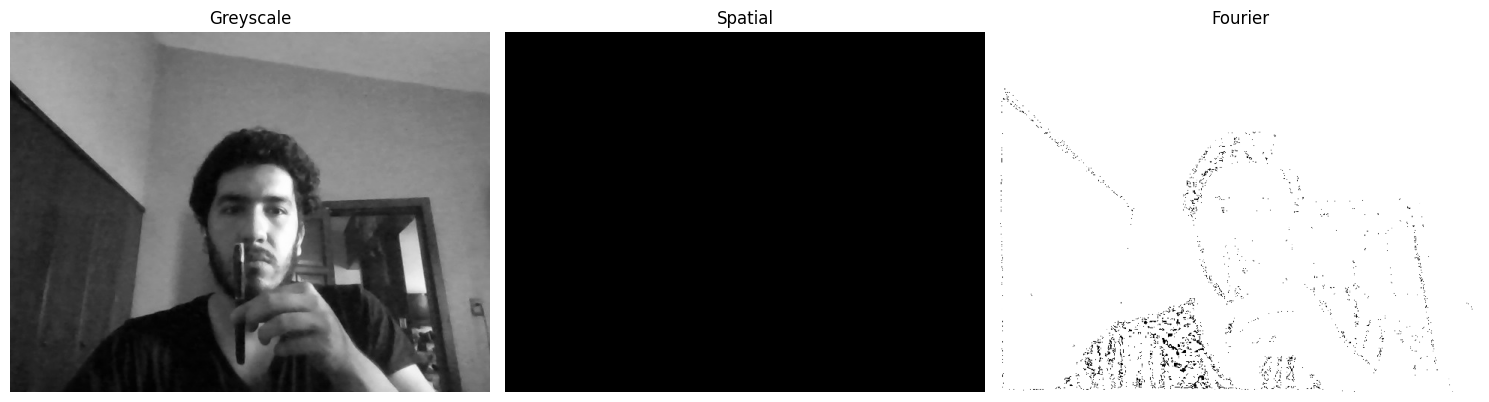

In [12]:
def homomorphic_filter_spatial(image, sigma=30, scale_factor=0.1):
    # Convert the image to float32 for processing
    image = np.float32(image) / 255.0

    # Apply logarithm
    log_image = np.log1p(image)

    # Create a Gaussian high-pass filter in the spatial domain
    kernel_size = (int(6*sigma+1), int(6*sigma+1))
    gaussian_kernel = cv.getGaussianKernel(kernel_size[0], sigma)
    low_pass = gaussian_kernel @ gaussian_kernel.T
    low_pass /= low_pass.max()
    high_pass = 1 - low_pass

    # Convolve the log image with the high-pass filter
    filtered_log_image = cv.filter2D(log_image, -1, high_pass)

    # Apply clamping and exponentiation with scaling to prevent overflow
    filtered_log_image = np.clip(filtered_log_image * scale_factor, -10, 10)  # Clamping the values
    filtered_image = np.expm1(filtered_log_image)

    # Normalize and convert to uint8
    filtered_image = cv.normalize(filtered_image, None, 0, 255, cv.NORM_MINMAX)
    filtered_image = np.uint8(filtered_image)

    return filtered_image

def homomorphic_filter_fourier(image, cutoff=30, gamma_low=0.5, gamma_high=2.0):
    image = np.float32(image) / 255.0

    # Apply logarithm
    log_image = np.log1p(image)

    # Fourier transform
    dft = cv.dft(log_image, flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Gaussian high-pass filter
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2
    x = np.linspace(-ccol, ccol, cols)
    y = np.linspace(-crow, crow, rows)
    x, y = np.meshgrid(x, y)
    radius = np.sqrt(x**2 + y**2)
    high_pass_filter = (gamma_high - gamma_low) * (1 - np.exp(-(radius**2) / (2 * (cutoff**2)))) + gamma_low

    # Filter the Fourier transformed image
    dft_shift[:, :, 0] *= high_pass_filter
    dft_shift[:, :, 1] *= high_pass_filter

    # Inverse Fourier transform
    dft_shift = np.fft.ifftshift(dft_shift)
    filtered_image = cv.idft(dft_shift)
    filtered_image = cv.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

    # Clamping and exponentiation with scaling to prevent overflow
    scale_factor = 0.01 
    filtered_image = np.clip(filtered_image * scale_factor, -10, 10)  # Clamping the values
    filtered_image = np.expm1(filtered_image)

    # Normalize
    filtered_image = cv.normalize(filtered_image, None, 0, 255, cv.NORM_MINMAX)
    filtered_image = np.uint8(filtered_image)

    return filtered_image

# Load the image in grayscale
gray_image = cv.imread("images/selfie.jpg", cv.IMREAD_GRAYSCALE)

# Apply the homomorphic filter in the spatial domain
filtered_image_spatial = homomorphic_filter_spatial(gray_image)
filtered_image_fourier = homomorphic_filter_fourier(gray_image)

plot_img(3,(15,6),["Greyscale", "Spatial", "Fourier"],[gray_image, filtered_image_spatial, filtered_image_fourier])

#### Implement and test your own versions of the
    IIR filter

General case:

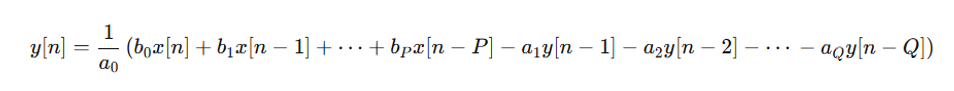

With case:

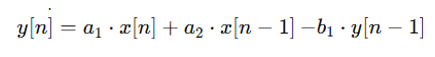

    FIR filter
General case:

    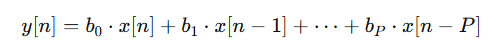
    

In [9]:
def iir_filter_generic(x, a, b):
    #it is necesary to obtain a and b coefficientes.
    P = len(b) - 1
    Q = len(a) - 1
    y = np.zeros_like(x)
    for n in range(max(P, Q), len(x)):
        y[n] = (1 / a[0]) * (np.dot(b, x[n:n-P-1:-1]) - np.dot(a[1:], y[n-1:n-Q-1:-1]))
    return y

def fir_filter_generic(x, b):
    P = len(b) - 1  #Order
    y = np.zeros_like(x)
    for n in range(P, len(x)):
        y[n] = np.dot(b, x[n:n-P-1:-1])
    return y

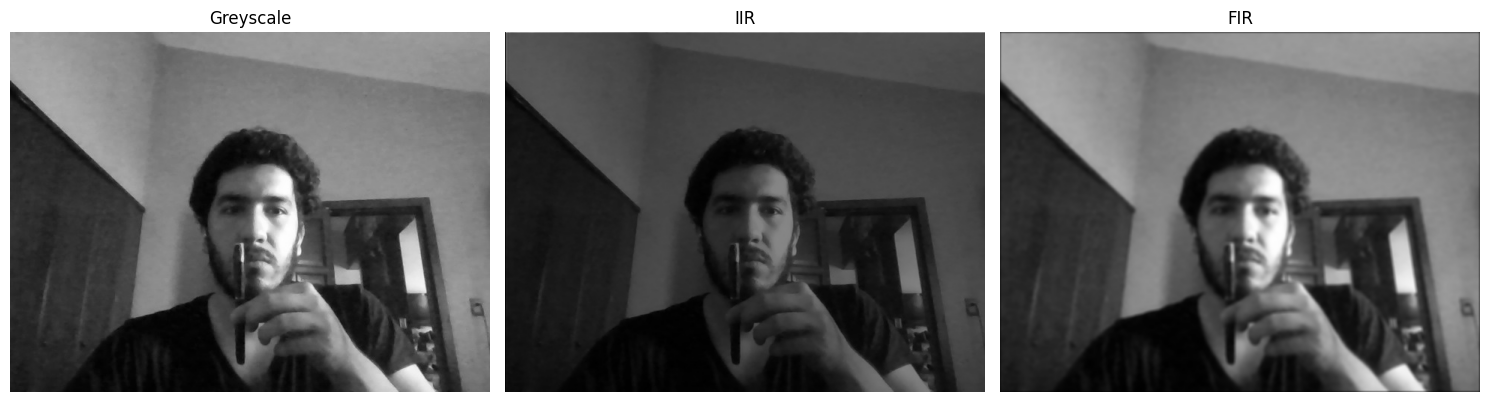

In [10]:
#for an image
def iir_filter_image(image, a1=0.5, a2=0.5, b1=0.5):
    rows, cols = image.shape
    filtered_image = np.zeros_like(image, dtype=np.float32)
    
    # Apply rows
    for i in range(rows):
        for j in range(1, cols):
            filtered_image[i, j] = a1 * image[i, j] + a2 * image[i, j-1] - b1 * filtered_image[i, j-1]
    
    # Apply columns
    for j in range(cols):
        for i in range(1, rows):
            filtered_image[i, j] = a1 * filtered_image[i, j] + a2 * filtered_image[i-1, j] - b1 * filtered_image[i-1, j]
    
    # Normalize 
    filtered_image = cv.normalize(filtered_image, None, 0, 255, cv.NORM_MINMAX)
    return np.uint8(filtered_image)


def fir_filter_image(image, kernel_size=3):
    # averaging kernel (for simplicity)
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
    rows, cols = image.shape
    
    pad_size = kernel_size // 2
    padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)

    filtered_image = np.zeros_like(image, dtype=np.float32)
    
    # apply the convolution
    for i in range(rows):
        for j in range(cols):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            
            # element-wise multiplication and sum
            filtered_value = np.sum(region * kernel)
            # Store
            filtered_image[i, j] = filtered_value
    
    # Normalize
    filtered_image = cv.normalize(filtered_image, None, 0, 255, cv.NORM_MINMAX)
    return np.uint8(filtered_image)

gray_image = cv.imread("images/selfie.jpg", cv.IMREAD_GRAYSCALE)

iir_filtered_image = iir_filter_image(gray_image)
fir_filtered_image = fir_filter_image(gray_image, kernel_size=5)

plot_img(3,(15,6),["Greyscale", "IIR", "FIR"],[gray_image, iir_filtered_image, fir_filtered_image])

### **(Edge Detection)** Use your own image.

#### Compute the image gradient of the grayscale image.
    Show your result as an RGB
        Red channel the Gradient Magnitude
        Blue channel the gradient angle
        Green channel the gray scale image

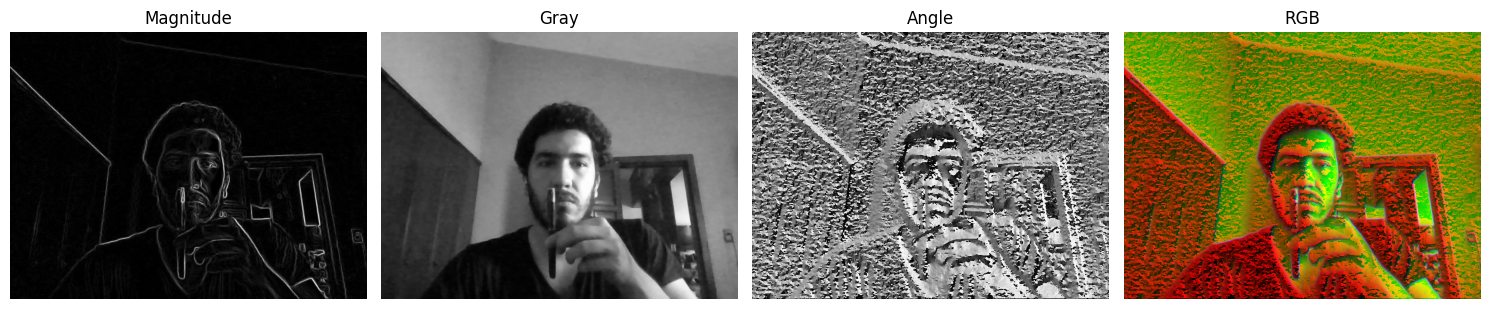

In [11]:
gray_image = cv.imread("images/selfie.jpg", cv.IMREAD_GRAYSCALE)

# Compute gradient in the x and y direction using kernel size of 3
grad_x = cv.Sobel(gray_image, cv.CV_64F, 1, 0, ksize=3)
grad_y = cv.Sobel(gray_image, cv.CV_64F, 0, 1, ksize=3)

# Compute gradient magnitude and angle
magnitude = cv.magnitude(grad_x, grad_y)
angle = cv.phase(grad_x, grad_y, angleInDegrees=True)

# Normalize
magnitude = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
angle = cv.normalize(angle, None, 0, 255, cv.NORM_MINMAX)

# Convert to uint8
magnitude = magnitude.astype(np.uint8)
angle = angle.astype(np.uint8)

# Stack the channels to create the RGB image
rgb_image = cv.merge([magnitude, gray_image, angle])

plot_img(4,(15,6),["Magnitude", "Gray", "Angle", "RGB"],[magnitude, gray_image, angle, rgb_image])

#### Using the zero-crossing property of the Laplacian:
    Show the localization of the edges of the previous image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


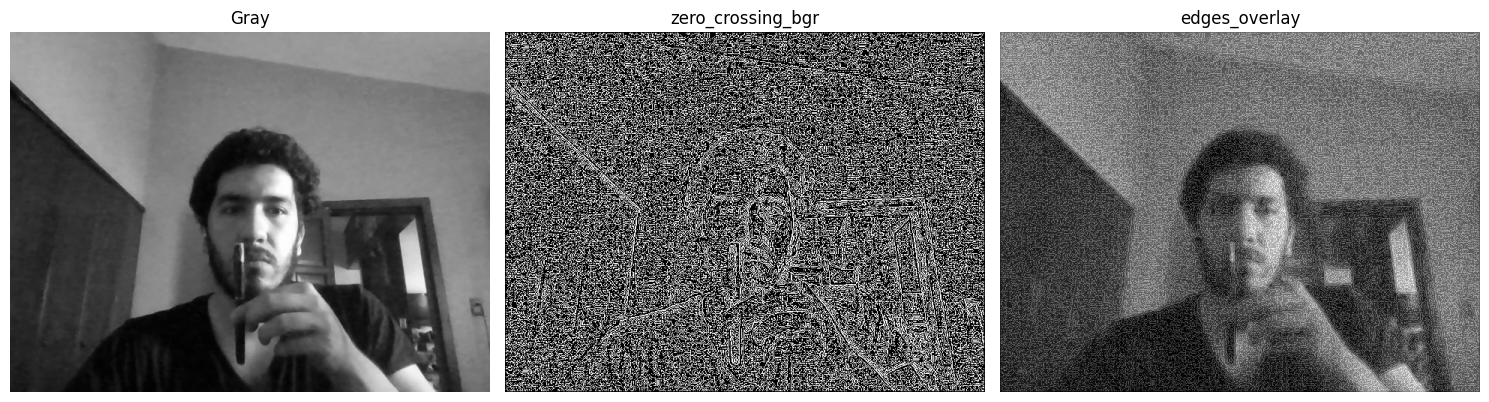

In [3]:
import cv2 as cv
import numpy as np

# Load the image in grayscale
gray_image = cv.imread("images/selfie.jpg", cv.IMREAD_GRAYSCALE)

# Apply the Laplacian filter to the grayscale image
laplacian = cv.Laplacian(gray_image, cv.CV_64F)

# Detect zero-crossings by checking where the Laplacian changes sign
# Create a binary mask for zero-crossings
zero_crossing = np.zeros_like(laplacian)
zero_crossing[1:-1, 1:-1] = (
    ((laplacian[1:-1, 1:-1] > 0) & (laplacian[1:-1, :-2] < 0)) |  # Left neighbors
    ((laplacian[1:-1, 1:-1] > 0) & (laplacian[1:-1, 2:] < 0))  |  # Right neighbors
    ((laplacian[1:-1, 1:-1] > 0) & (laplacian[:-2, 1:-1] < 0)) |  # Top neighbors
    ((laplacian[1:-1, 1:-1] > 0) & (laplacian[2:, 1:-1] < 0))     # Bottom neighbors
).astype(np.uint8) * 255

# Convert the grayscale image to BGR for compatibility with addWeighted
gray_bgr = cv.cvtColor(gray_image, cv.COLOR_GRAY2BGR)

# Convert zero_crossing to BGR as well to match types
zero_crossing_bgr = cv.merge([zero_crossing, zero_crossing, zero_crossing])

# Ensure both images are of the same type
gray_bgr = gray_bgr.astype(np.float32)
zero_crossing_bgr = zero_crossing_bgr.astype(np.float32)

# Overlay the detected edges on the original grayscale image
edges_overlay = cv.addWeighted(gray_bgr, 0.7, zero_crossing_bgr, 0.3, 0)

# Convert the result back to uint8 for proper display
edges_overlay = np.clip(edges_overlay, 0, 255).astype(np.uint8)

plot_img(3,(15,6),["Gray", "zero_crossing_bgr", "edges_overlay"],[gray_image, zero_crossing_bgr, edges_overlay])


####    Compute the Canny edges:
    Use at least three different values of sigma.

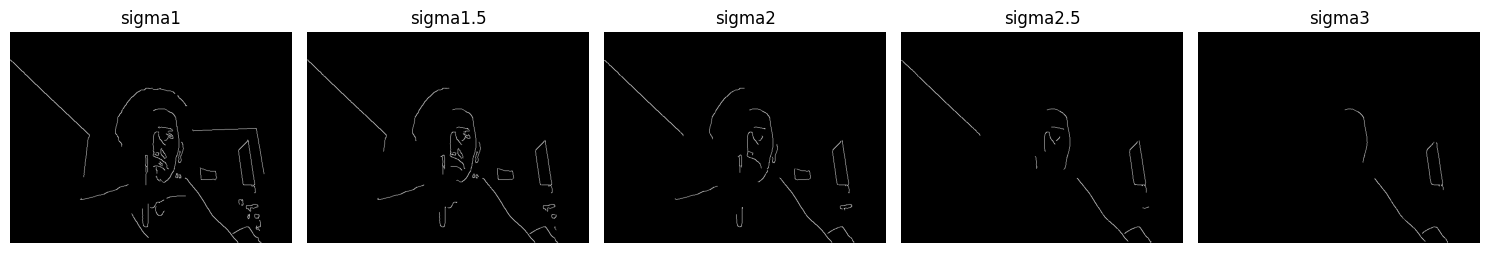

In [6]:
gray_image = cv.imread("images/selfie.jpg", cv.IMREAD_GRAYSCALE)
sigma_values = [1, 1.5, 2, 2.5, 3]
canny_edges = []

for sigma in sigma_values:
    # GaussianBlur
    blurred_image = cv.GaussianBlur(gray_image, (0, 0), sigma)
    # Canny edges
    edges = cv.Canny(blurred_image, 100, 200)  # You can adjust the thresholds (100, 200) as needed
    canny_edges.append(edges)

plot_img(len(canny_edges),(15,6),["sigma1", "sigma1.5", "sigma2", "sigma2.5", "sigma3"],canny_edges)